## **Competencia**

In [ ]:
%load_ext lab_black

In [573]:
import os
import datetime
import urllib
import gc
import pickle
from multiprocessing.pool import ThreadPool

import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import (
    SHConfig,
    MimeType,
    CRS,
    BBox,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    DataCollection,
    bbox_to_dimensions,
    DownloadRequest,
)
from IPython.display import Image

In [28]:
def plot_coordinates(lat, long):
    #https://gis.stackexchange.com/questions/330798/how-to-put-a-google-map-image-or-any-other-map-layers-under-my-utm-cordinates
    center_lat = lat.mean()
    center_long = long.mean()
    token = "pk.eyJ1Ijoia2FwYXN0b3IiLCJhIjoiY2p3eTg3eWJoMG1jZjQ4bzZmcGg5c3F3cSJ9.vhyCyD9xDDGP9EQnhB9xtA"
    tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
    my_map = folium.Map(location=[center_lat, center_long], tiles=tileurl, attr='Mapbox', max_zoom=30, zoom_start=15)
    for i in range(len(lat)):
        location = (lat[i], long[i])
        folium.CircleMarker(location=[lat[i], long[i]], radius=2).add_to(my_map)
    return my_map

In [3]:
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)

In [451]:
path = "/home/augusto/Github/DesafioAgTech2020/"

etiquetas = pd.read_csv(path + "dataset/Etiquetas.csv")
train = pd.read_csv(path + "dataset/data_train.csv")
test = pd.read_csv(path + "dataset/data_test.csv")

In [452]:
train = pd.merge(train, etiquetas, on="Cultivo")
train["Tipo"] = train["Tipo"].apply(
    lambda x: x.replace(" ", "_").replace(",", "").lower()
)

In [ ]:
train.boxplot(column=["Elevacion"], by="Cultivo", figsize=(15,6))

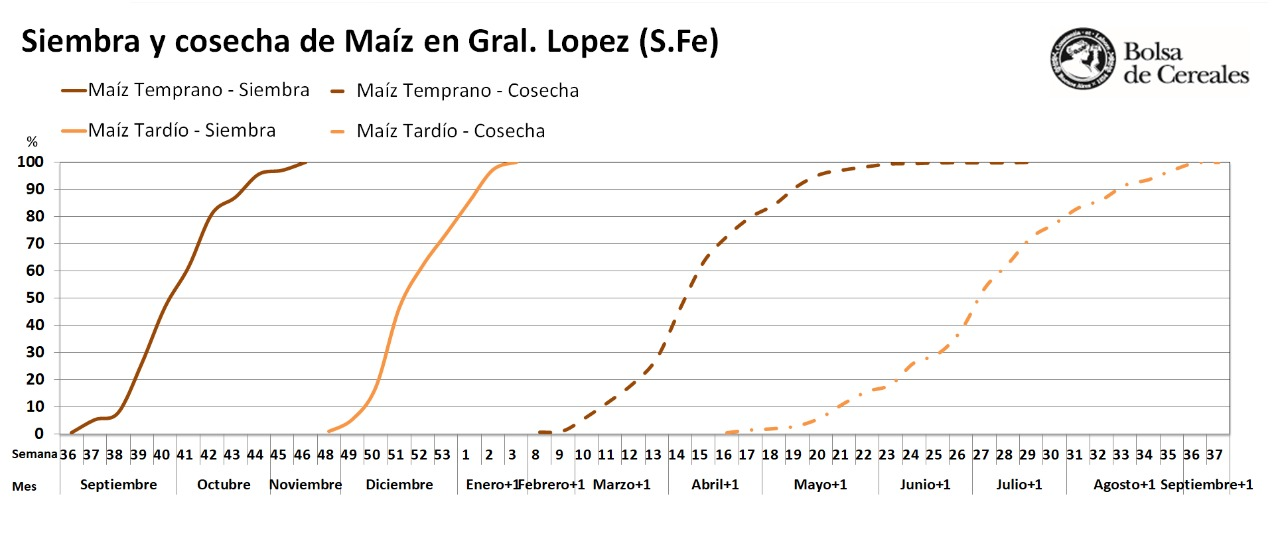

In [5]:
Image(path + "www/bc_maiz.jpeg")

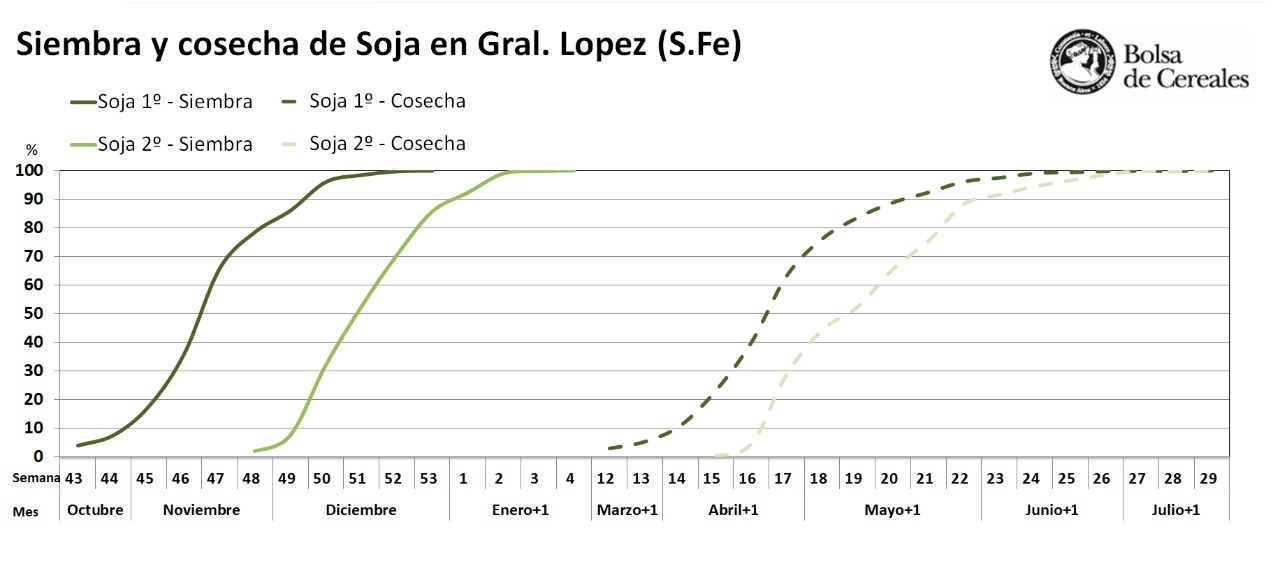

In [6]:
Image(path + "www/bc_soja.jpeg")

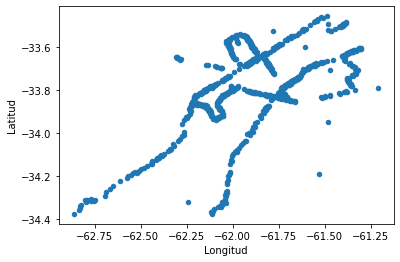

In [7]:
train.plot.scatter(x="Longitud", y="Latitud")

In [29]:
train_map = plot_coordinates(train["Latitud"], train["Longitud"])

In [311]:
train_map

**SENTINELHUB**

In [31]:
CLIENT_ID = '81bf3f52-6953-414b-a539-358a3fed12d8'
CLIENT_SECRET = 'a})ewR[qL#ZTzB(nW?ui3;m18M{7v!eP:GN6axyy'

In [563]:
class SentinelClient:
    def __init__(self, client_id, client_secret):
        self.client_id = client_id
        self.client_secret = client_secret
        self.client = self.set_client(client_id, client_secret)

    def set_client(self, client_id, client_secret):
        if not client_id or not client_secret:
            raise Exception(
                "Need to provide SentinelHub credentials to use its services"
            )
        config = SHConfig()
        config.sh_client_id = client_id
        config.sh_client_secret = client_secret
        return config

    def get_bbox(self, lat, long, offset=0.002):
        bbox = [long - offset, lat - offset, long + offset, lat + offset]
        bbox = BBox(bbox=bbox, crs=CRS.WGS84)
        return bbox

    def get_size(self, bbox, resolution=10):
        size = bbox_to_dimensions(bbox, resolution=resolution)
        return size

    def define_bands(self, bands):
        evalscript = """
        //VERSION=3
        function setup() {
            return {
                input: [{
                    bands: %s,
                }],
                output: {
                    bands: %s
                }
            };
        }

        function evaluatePixel(sample) {
            return %s;
        }
        """
        format_bands = [f"sample.{band}" for band in bands]
        format_bands = str(format_bands).replace("'", "")
        bands_query = evalscript % (bands, len(bands), format_bands)
        bands_query = bands_query.replace("'", '"')
        return bands_query

    def get_image(self, lat, long, offset, bands, start_date, end_date, resolution):
        bbox = self.get_bbox(lat, long, offset)
        image_request = SentinelHubRequest(
            evalscript=self.define_bands(bands),
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(start_date, end_date),
                    mosaicking_order="leastCC",
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=bbox,
            size=self.get_size(bbox, resolution),
            config=self.client,
        )
        image = image_request.get_data()
        image = image[0] if image else None
        return image

    def image_to_disk(self, image, filename):
        path = os.path.dirname(filename)
        if path:
            os.makedirs(path, exist_ok=True)
        with open(filename, "wb") as f:
            pickle.dump(image, f)

    def download_to_disk(
        lat, long, offset, bands, start_date, end_date, resolution, label=None
    ):
        image = self.get_images(
            lat, long, offset, bands, start_date, end_date, resolution
        )
        self.image_to_disk(image, f"{lat}_{long}", path=path + "dataset/" + label)
        del image
        gc.collect()

    def bulk_download_images(self, download_to_disk_params):
        images = thread_pool.map(lambda x: self.get_image(**x), download_to_disk_params)
        return images

In [565]:
sentinel_client = SentinelClient(CLIENT_ID, CLIENT_SECRET)

In [523]:
offset = 0.002
bands = ["B02", "B03", "B04", "B08", "B11", "B12"]
start_date = "%s-01-15"
end_date = "%s-02-20"
resolution = 5

In [575]:
year = {"19/20": "2020", "18/19": "2019"}
params = [
    {
        "lat": row.Latitud,
        "long": row.Longitud,
        "offset": offset,
        "bands": bands,
        "start_date": start_date % year.get(row.Campania),
        "end_date": end_date % year.get(row.Campania),
        "resolution": resolution,
        "label": row.Tipo,
    }
    for _, row in train.iterrows()
]

In [580]:
def bulk_download_images(
    client, lat, long, offset, bands, start_date, end_date, resolution, label=None
):
    image = client.get_image(lat, long, offset, bands, start_date, end_date, resolution)
    filename = os.path.join(os.getcwd(), "images", label, f"{lat}_{long}")
    client.image_to_disk(image, filename)
    del image
    gc.collect()

In [ ]:
thread_pool = ThreadPool(8)
thread_pool.map(lambda x: bulk_download_images(sentinel_client, **x), params)

**Train Model**

In [583]:
!pip3 install keras

     |████████████████████████████████| 4.0 MB 8.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/augusto/.python_venvs/local/bin/python3 -m pip install --upgrade pip' command.


In [585]:
!export TMPDIR=$HOME/tmp

In [587]:
!echo $TMPDIR

In [586]:
!pip3 install tensorflow

     |███████████                     | 109.9 MB 6.2 MB/s eta 0:00:34ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device    | 47.6 MB 6.2 MB/s eta 0:00:45     |███████▍                        | 73.9 MB 7.1 MB/s eta 0:00:35

You should consider upgrading via the '/home/augusto/.python_venvs/local/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)

In [ ]:
ImageDataGenerator.flow_from_directory(
    directory,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset=None,
    interpolation="nearest",
)


In [ ]:
inp = keras.layers.Input(shape=(64, 64, 3), name='image_input')

vgg_model = VGG19(weights='imagenet', include_top=False)
vgg_model.trainable = False

x = keras.layers.Flatten(name='flatten')(vgg_model)
x = keras.layers.Dense(512, activation='relu', name='fc1')(x)
x = keras.layers.Dense(512, activation='relu', name='fc2')(x)
x = keras.layers.Dense(10, activation='softmax', name='predictions')(x)

new_model = keras.models.Model(inputs=inp, outputs=x)
new_model.compile(optimizer='adam', loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [ ]:
pickle.load(open(os.path.join(img_path, filename), "rb"))

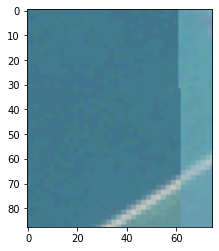

In [526]:
plt.imshow(asd[:, :, [2, 1, 0]] * 6.5 / 255)

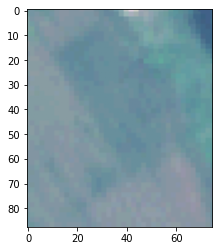

In [341]:
plt.imshow(asd[0][:, :, [2, 1, 0]] * 6.5 / 255)

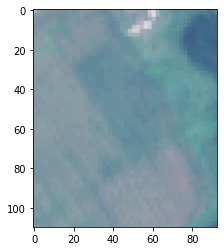

In [345]:
plt.imshow(asd[0][:, :, [2, 1, 0]] * 6.5 / 255)

In [316]:
params[62]

{'lat': -33.87152662155488,
 'long': -62.17255408371528,
 'offset': 0.005,
 'bands': ['B02', 'B03', 'B04', 'B08', 'B11', 'B12'],
 'start_date': '2020-01-30',
 'end_date': '2020-02-20',
 'resolution': 5}

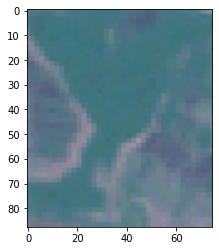

In [327]:
plt.imshow(asd[0][:, :, [2, 1, 0]] * 6.5 / 255)

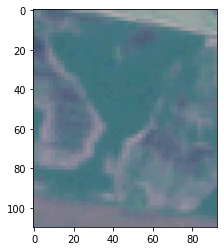

In [335]:
plt.imshow(asd[0][:, :, [2, 1, 0]] * 6.5 / 255)

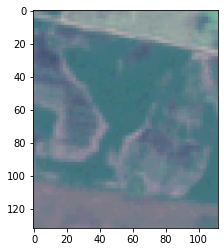

In [331]:
plt.imshow(asd[0][:, :, [2, 1, 0]] * 6.5 / 255)

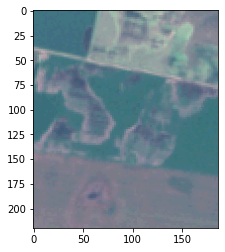

In [318]:
plt.imshow(asd[0][:, :, [2, 1, 0]] * 6.5 / 255)

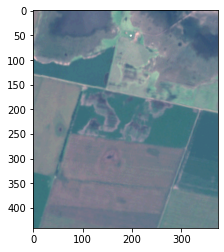

In [322]:
plt.imshow(asd[0][:, :, [2, 1, 0]] * 6.5 / 255)

In [242]:
# thread_pool = ThreadPool(8)
asd = list(map(lambda x: sentinel_client.get_image(**x), params[10]))

In [70]:
ndvi = np.stack((true_color_imgs[0][:, :, 3] - true_color_imgs[0][:, :, 0]) / (true_color_imgs[0][:, :, 3] + true_color_imgs[0][:, :, 0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


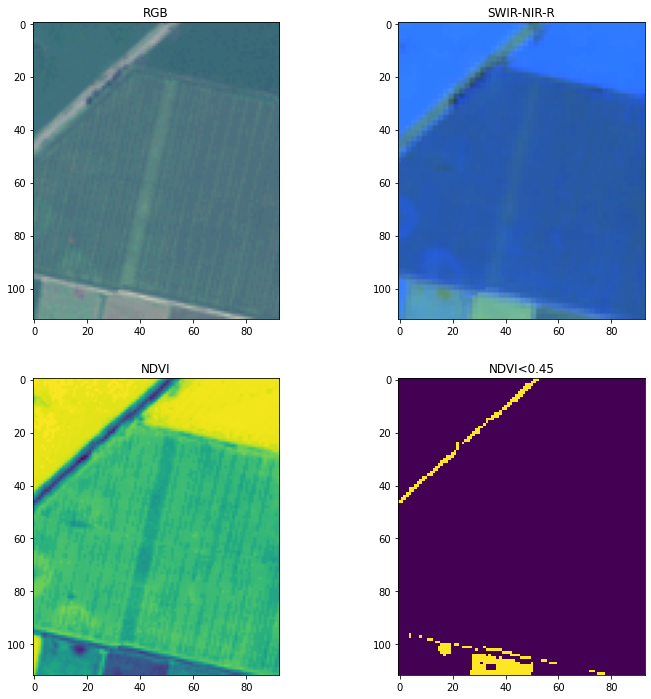

In [82]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1) , plt.imshow(true_color_imgs[0][:, :, :3]*6.3/255), plt.title("RGB")
plt.subplot(2,2,2) , plt.imshow(true_color_imgs[0][:, :, [5,4,3]]*0.01) ,plt.title("SWIR-NIR-R")
plt.subplot(2,2,3) , plt.imshow(ndvi), plt.title("NDVI")
plt.subplot(2,2,4) , plt.imshow(ndvi < 0.5, interpolation='nearest') ,plt.title("NDVI<0.45");

In [195]:
print(f'Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.')
print(f'Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}')

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (112, 93, 4)
